# T-Maze Inference for Planning with GBFE

In [38]:
using Pkg
Pkg.activate("../..")
# Pkg.instantiate()

  Activating environment at `d:\Articles\EpistemicMessagePassing\Project.toml`


In [39]:
using LinearAlgebra
using ForneyLab
using Plots
using ForwardDiff: hessian

# T-maze layout
# [2| |3]
#   | |
#   |1|
#   |4|

include("factor_nodes/GFECategorical.jl")
include("update_rules/GFECategorical.jl")
;

# Model

In [40]:
T = 2

fg = FactorGraph()

u = Vector{Variable}(undef, T)
x = Vector{Variable}(undef, T)

@RV x_t_min ~ Categorical(placeholder(:D_t_min, dims=(8,)))

x_k_min = x_t_min
for k=1:T
    @RV u[k]
    @RV x[k] ~ Transition(x_k_min, u[k],id=:x_*k)

    placeholder(u[k], :u, index=k, dims=(8,8))
    GFECategorical(x[k], 
                   placeholder(:A, dims=(16,8), var_id=:A_*k), 
                   placeholder(:C, dims=(16,), index=k, var_id=:C_*k),
                   n_factors=8)
    
    x_k_min = x[k]
end
;

In [41]:
q = PosteriorFactorization(fg)
algo = messagePassingAlgorithm(x_t_min, free_energy=true)
code = algorithmSourceCode(algo, free_energy=true)
eval(Meta.parse(code))
;

In [42]:
println(code)

begin

function init()

messages = Array{Message}(undef, 10)

messages[5] = Message(vague(Categorical, (8,)))
messages[8] = Message(vague(Categorical, (8,)))

return messages

end

function step!(data::Dict, marginals::Dict=Dict(), messages::Vector{Message}=Array{Message}(undef, 10))

messages[1] = ruleSPGFECategoricalOutDPP(messages[8], marginals[:x_1], Message(MatrixVariate, PointMass, m=data[:A]), Message(Multivariate, PointMass, m=data[:C][1]))
messages[2] = ruleSPCategoricalOutNP(nothing, Message(Multivariate, PointMass, m=data[:D_t_min]))
messages[3] = ruleSPTransitionOutNCP(nothing, messages[2], Message(MatrixVariate, PointMass, m=data[:u][1]))
messages[4] = ruleSPEqualityCategorical(messages[3], messages[1], nothing)
messages[5] = ruleSPTransitionOutNCP(nothing, messages[4], Message(MatrixVariate, PointMass, m=data[:u][2]))
messages[6] = ruleSPGFECategoricalOutDPP(messages[5], marginals[:x_2], Message(MatrixVariate, PointMass, m=data[:A]), Message(Multivariate, PointMass, m=dat

# Results

In [43]:
# Reward probability and utility, uncomment scenario of interest
α = 0.9; c = 2.0

include("environment.jl")
include("agent.jl")
include("helpers.jl")

(A, B, C, D) = constructABCD(α, c)
C_t = [C, C] # Goal prior sequence
;

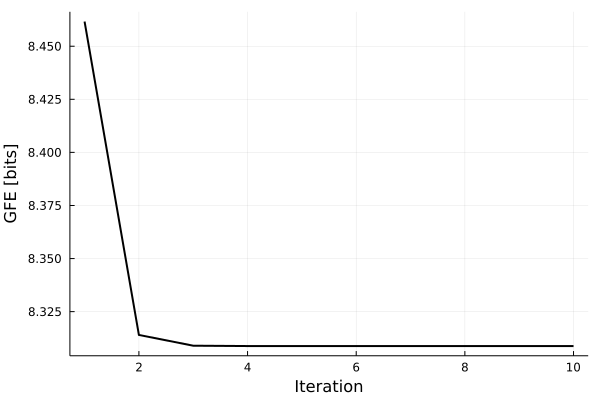

In [44]:
# Single policy
pi = [4, 2]

n_its = 10
G = zeros(n_its)

data = Dict(:u       => [B[pi[1]], B[pi[2]]],
            :A       => A,
            :C       => C_t,
            :D_t_min => D)

marginals = Dict{Symbol, ProbabilityDistribution}(
    :x_t_min => ProbabilityDistribution(Univariate, Categorical, p=D),
    :x_1 => ProbabilityDistribution(Univariate, Categorical, p=asym(8)),
    :x_2 => ProbabilityDistribution(Univariate, Categorical, p=asym(8)))

messages = init()

for k=1:n_its
    step!(data, marginals, messages)
    G[k] = freeEnergy(data, marginals)
end
  
G = G./log(2) # Convert to bits

plot(1:n_its, G, color=:black, grid=true, linewidth=2, legend=false, xlabel="Iteration", ylabel="GFE [bits]")

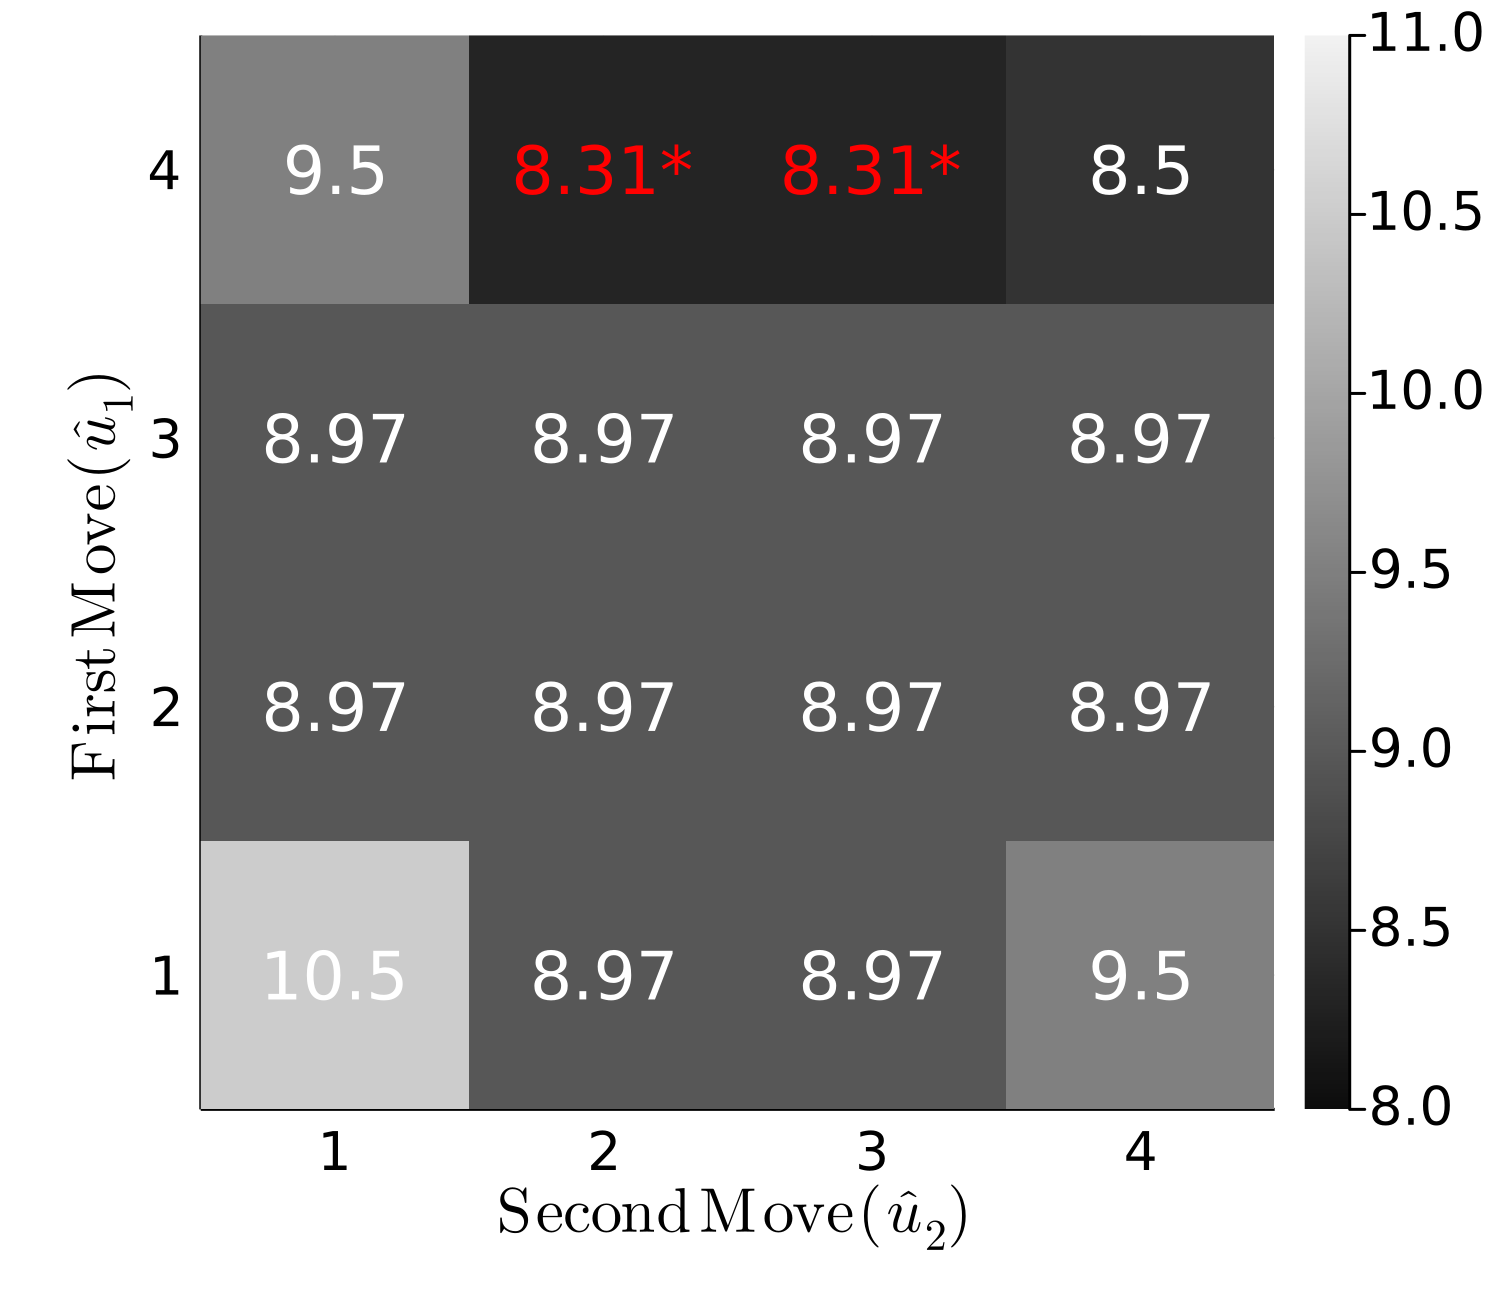

In [45]:
# GBFE for all policies
GBFE = evaluatePoliciesGBFE(A, B, C_t, D, n_its=n_its)
plotResults(GBFE, clim=(8.0,11.0), dpi=300, highlight=minimum)
#savefig("GBFE_c_$(c)_a_$(α).png")